In [16]:
# standard python utilities
import os
from os.path import join, basename,dirname
import sys
import glob

import pandas as pd
import numpy as np
import geopandas as gpd

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt


In [3]:
git_dir = os.getcwd()
while basename(git_dir) != 'GitHub':
    git_dir = dirname(git_dir)
usr_dir = os.getcwd()
while basename(usr_dir) != 'Users':
    temp = basename(usr_dir)
    usr_dir = dirname(usr_dir)
usr_dir += '/'+temp

py_dir = git_dir +'/CosumnesRiverRecharge/python_utilities/'
## Set up directory referencing
# Package data
gwfm_dir = join(usr_dir,'Box/research_cosumnes/GWFlowModel')
proj_dir = join(gwfm_dir,'Oneto_Denier')
# dat_dir = proj_dir+'Stream_level_data/'
# fig_dir = proj_dir+'/Streambed_seepage/figures/'



In [4]:
sw_dir = join(dirname(gwfm_dir), 'Oneto_Denier', 'Cosumnes_GageHeight')


In [5]:
fn = pd.Series(os.listdir(sw_dir))
fn = fn[fn.str.contains(r'\d{4}.xlsx')]

fn

0    Depth_WSE_WY2012.xlsx
1    Depth_WSE_WY2013.xlsx
2    Depth_WSE_WY2014.xlsx
3    Depth_WSE_WY2015.xlsx
4    Depth_WSE_WY2016.xlsx
dtype: object

In [6]:
# most significant loggers are installed in WY2014
xl_fn = join(sw_dir, 'Depth_WSE_WY2014.xlsx')
sw_meta = pd.read_excel(xl_fn, header=0, skiprows=[1])
# extract loggers atcually in the field
sw_name = pd.DataFrame(pd.ExcelFile(xl_fn).sheet_names[1:], columns=['sheet'])
sw_name['name'] = sw_name.iloc[:,0].str.upper().values # standardize names as capitalized

# ll_name = sw_meta['Logger Location']


In [58]:
sw_select = sw_meta[sw_meta['Logger Type'].isin(['Floodplain'])]['Logger Location']
sw_load = sw_name.loc[sw_name.name.isin(sw_select),'sheet']
# sw_name, sw_select
sw_load


2    NW_Splay
3    Site_115
4    Site_201
5    Site_208
6    Site_104
7    Site_108
Name: sheet, dtype: object

In [59]:
sw_gdf = gpd.GeoDataFrame(sw_meta, geometry=gpd.points_from_xy(sw_meta.Easting, sw_meta.Northing), crs='epsg:32610')

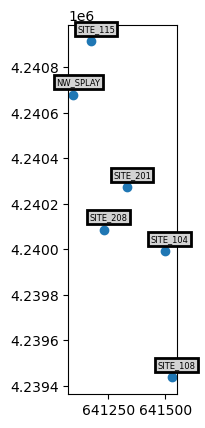

In [60]:
fig,ax = plt.subplots()
gdf_plt = sw_gdf.loc[sw_gdf['Logger Location'].isin(sw_load.str.upper())]
gdf_plt.plot(ax=ax)
gdf_plt
gdf_plt.apply(lambda x: ax.annotate(x['Logger Location'], xy=x.geometry.coords[0], ha='center', fontsize=6,
                                    xytext = (5,10), textcoords='offset pixels',
#                                     arrowprops = {'shrink':1},
                                    bbox=dict(boxstyle="square,pad=0.3", fc="lightgrey", ec="black", lw=2)
                                                        ),axis=1);
# sw_load
# sw_gdf


In [62]:
sw_all = pd.DataFrame()
for n in sw_load:
# for n in [sw_name[0]]:
    sw_data = pd.read_excel(xl_fn, sheet_name=n, header=0)
    sw_data['name'] = n
    sw_all = pd.concat((sw_all, sw_data))

# ll_name.loc[0]
# create datetime column
sw_all['dt'] = pd.to_datetime(sw_all.Date.astype(str)+' '+sw_all.Time.astype(str))
sw_all = sw_all.set_index('dt')

In [117]:
# USGS presents flow in cfs (cubic feet per second)
inflow_in = pd.read_csv(join(gwfm_dir, 'SFR_data','MB_15min_2010_10_01.csv'),
                             index_col = 'Datetime', parse_dates = True)
inflow_in = inflow_in.dropna(axis=1, how='all')

In [122]:
inflow_in.index

DatetimeIndex(['2010-10-01 00:00:00', '2010-10-01 00:15:00',
               '2010-10-01 00:30:00', '2010-10-01 00:45:00',
               '2010-10-01 01:00:00', '2010-10-01 01:15:00',
               '2010-10-01 01:30:00', '2010-10-01 01:45:00',
               '2010-10-01 02:00:00', '2010-10-01 02:15:00',
               ...
               '2021-09-30 21:30:00', '2021-09-30 21:45:00',
               '2021-09-30 22:00:00', '2021-09-30 22:15:00',
               '2021-09-30 22:30:00', '2021-09-30 22:45:00',
               '2021-09-30 23:00:00', '2021-09-30 23:15:00',
               '2021-09-30 23:30:00', '2021-09-30 23:45:00'],
              dtype='datetime64[ns]', name='Datetime', length=385483, freq=None)

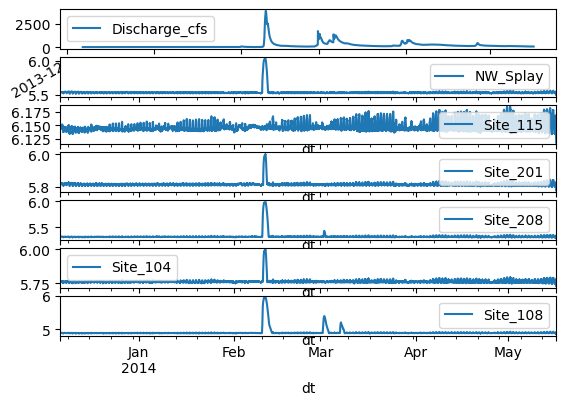

In [123]:

fig,ax=plt.subplots(1+len(sw_load),1)
inflow_in[sw_all.index.min():sw_all.index.max()].plot(ax=ax[0])

for nn, n in enumerate(sw_load):
    sw_all[sw_all.name==n].plot(y='WSE_m', ax=ax[1+nn],label=n)
# inflow_in.index, sw_all.dt

<Axes: xlabel='Date'>

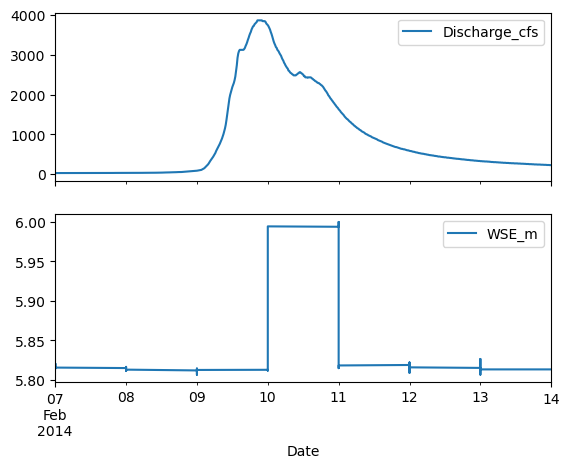

In [126]:
min_date = pd.to_datetime('2014-2-7')
max_date = pd.to_datetime('2014-2-14')
fig,ax = plt.subplots(2,1, sharex=True)
inflow_in[min_date:max_date].plot(ax=ax[0])
sw_201 = sw_all[sw_all.name=='Site_201']
sw_201[min_date:max_date].plot(x='Date',y='WSE_m', ax=ax[1])

In [147]:
fld_min = sw_201[sw_201.WSE_m>5.9].index.min()
inflow_in[fld_min - pd.DateOffset(hours=13):]
# pd.DateOffset?

Discharge_cfs
Datetime                          
2014-02-09 22:30:00        3840.00
2014-02-09 22:45:00        3840.00
2014-02-09 23:00:00        3840.00
2014-02-09 23:15:00        3820.00
2014-02-09 23:30:00        3780.00
...                            ...
2021-09-30 22:45:00           5.67
2021-09-30 23:00:00           5.67
2021-09-30 23:15:00           5.67
2021-09-30 23:30:00           5.67
2021-09-30 23:45:00           5.67

[267598 rows x 1 columns]

In [148]:
inflow_in[min_date:max_date].max()*0.3048**3

Discharge_cfs    109.303028
dtype: float64

There is definitely some flooding under the non-reconnected scenario but the threshold seems higher? And perhaps less flow makes it there.  

Following levee removal in 1995 at the lower site Florsheim et al 2006 found flows from 23-25.5 cms led to floodplain connection. This suggests the flow connection requirement was higher prior to removal.  

The flow threshold pre-restoration could be estimated with Manning's equation at LWC gage if we could create a cross-section before and after.  

Map key dates with floods at 23, 50, 75, 100, 150, 200 cms to see dates when we should reference data sources like satellite. We know from Whipple thesis that RBI recorded inundation at 300 cms with aerial photographs.